# sensitivity analysis of water mass divisions

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import interpn
import cmocean as cm
import gsw
import datetime as dt
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('./filtered_obs.csv')

In [3]:
obs = obs[(obs['latitude (degrees_north)']>=40) & (obs['latitude (degrees_north)']<=50.8)].reset_index() # decreases from 1006797 to 883969
obs.drop(columns=['index','Unnamed: 0.1','Unnamed: 0'],inplace=True)


In [4]:
obs.columns

Index(['time', 'longitude (degrees_east)', 'latitude (degrees_north)',
       'depth (m)', 'pressure (dbar)', 'temperature (degC)',
       'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)', 'NO2 (uM)',
       'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'TA (uM)',
       'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Cd (nmol kg-1)',
       'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'source', 'Nstar (umol kg-1)',
       'spice', 'Nstar (uM)', 'TA (umol/kg)', 'DIC (umol/kg)',
       'Carbonate (umol/kg)', 'geometry', 'location', 'month'],
      dtype='object')

In [5]:
# density column 
CT = gsw.CT_from_t(obs['salinity (g kg-1)'],obs['temperature (degC)'],obs['pressure (dbar)'])
rho = gsw.rho_alpha_beta(np.array(obs['salinity (g kg-1)']), CT, np.array(obs['pressure (dbar)']))[0]
obs['density (kg m-3)'] = rho


# TA-DIc column
obs['[TA-DIC]'] = obs['TA (umol/kg)'] - obs['DIC (umol/kg)']

## Functions

In [ ]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28,35
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,ax, x, y):
    if x == 'salinity (g kg-1)':
        smin, smax = 28,35
    else:
        smin, smax = np.nanmean(df[x]) - 4*np.nanstd(df[x]),np.nanmean(df[x]) + 4*np.nanstd(df[x])
    tmin = np.nanmean(df[y]) - 4*np.nanstd(df[y])
    tmax = np.nanmean(df[y]) + 4*np.nanstd(df[y])

    salt = df[x].reset_index(drop=True)
    temp = df[y].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    scat = ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    # ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    if y == 'temperature (degC)' and x == 'salinity (g kg-1)':
        # density
        CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def depth_tracer(df,ax, x, y):
    if y == 'salinity (g kg-1)':
        smin, smax = 28,35
    elif y == 'depth (m)':
        smin, smax = 0,500
    tmin = np.nanmean(df[x]) - 4*np.nanstd(df[x])
    tmax = np.nanmean(df[x]) + 4*np.nanstd(df[x])

    salt = df[y].reset_index(drop=True)
    temp = df[x].reset_index(drop=True)

    bin = [np.linspace(tmin,tmax,100),np.linspace(smin,smax,100)]
    data, x_e, y_e = np.histogram2d(temp,salt, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([temp,salt]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(temp,salt, c=z, cmap=cm.cm.dense,s=1)

    ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([smin,smax])
    ax.set_xlim([tmin,tmax])

    if x == 'temperature (degC)' and y == 'salinity (g kg-1)':
        # density
        CS=ax.contour(t,SA,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

In [7]:
######################
# BOX PLOT FUNCTIONS #
######################

def box(df,bools,property,ax,**kwargs):
    tracer = [df[property][boo] for boo in bools]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True, widths=0.3)
    # ticks = [str(len(t_filter[i])) for i in range(len(regions))]
    # ax.set_xticklabels(ticks,rotation=30,ha='right',fontsize=9)
    ax.set_ylabel(property)

    return bplot

In [8]:
obs['region'] = 'none'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']>=120)] = 'offshore deep'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']<120)] = 'offshore surface'
obs.region[(obs.location == 'shelf') & (obs['latitude (degrees_north)'] >= 49)] = 'north'
obs.region[(obs.location == 'shelf') & (obs['latitude (degrees_north)'] <= 47.3)] = 'south'
obs.region[(obs.location == 'slope') & (obs['latitude (degrees_north)'] >= 49) & (obs['depth (m)'] <= 200)] = 'north'
obs.region[(obs.location == 'slope') & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7)] = 'south'
obs.region[(obs.location == 'slope') & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7)] = 'cuc'
obs.region[obs['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

## South

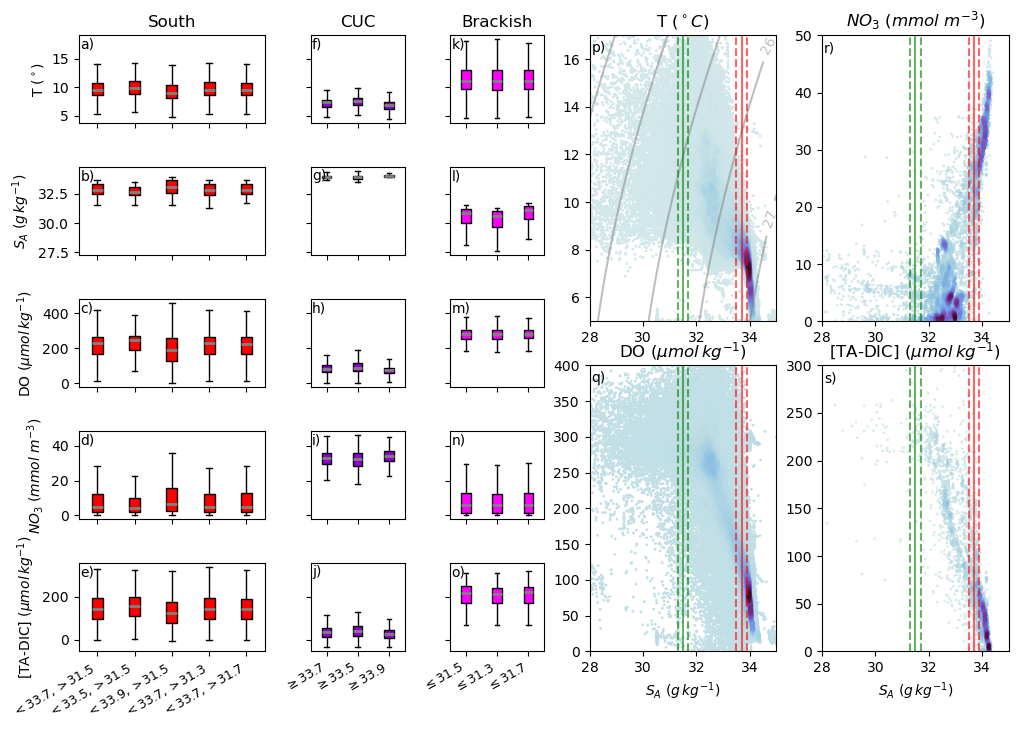

In [11]:
# box plots of properties depending on salinity split

fig = plt.figure(constrained_layout=False, figsize=[12,8])
gs = GridSpec(10, 21, figure=fig)
# south shelf
ax1 = fig.add_subplot(gs[0:2, 0:5])
ax2 = fig.add_subplot(gs[2:4, 0:5])
ax3 = fig.add_subplot(gs[4:6, 0:5])
ax4 = fig.add_subplot(gs[6:8, 0:5])
ax5 = fig.add_subplot(gs[8:, 0:5])

# cuc
ax6 = fig.add_subplot(gs[0:2, 5:8])
ax7 = fig.add_subplot(gs[2:4, 5:8])
ax8 = fig.add_subplot(gs[4:6, 5:8])
ax9 = fig.add_subplot(gs[6:8, 5:8])
ax10 = fig.add_subplot(gs[8:, 5:8])

# brackish
ax11 = fig.add_subplot(gs[0:2, 8:11])
ax12 = fig.add_subplot(gs[2:4, 8:11])
ax13 = fig.add_subplot(gs[4:6, 8:11])
ax14 = fig.add_subplot(gs[6:8, 8:11])
ax15 = fig.add_subplot(gs[8:, 8:11])

# TS 
axa = fig.add_subplot(gs[0:5, 11:16])
axd = fig.add_subplot(gs[5:, 16:])
axb = fig.add_subplot(gs[5:, 11:16])
axc = fig.add_subplot(gs[0:5, 16:])

properties = ['temperature (degC)','salinity (g kg-1)','DO (umol kg-1)', 'NO3 (uM)','[TA-DIC]']
prop_labels = ['T ($^\circ$)','$S_A$ ($g\, kg^{-1}$)', 'DO ($\mu mol \,kg^{-1}$)','$NO_3$ ($mmol\,\,m^{-3}$)','[TA-DIC] ($\mu mol \,kg^{-1}$)']
bools = [((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7-0.2) & (obs['salinity (g kg-1)'] > 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7+0.2) & (obs['salinity (g kg-1)'] > 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5-0.2),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5+0.2)]
axs = [ax1,ax2,ax3,ax4,ax5]
for i in range(len(properties)):
    bplot = box(obs,bools,properties[i],axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_ylabel(prop_labels[i])
    for patch in bplot['boxes']:
        patch.set_facecolor('red')
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

bools = [((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7-0.2),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7+0.2)]
axs = [ax6,ax7,ax8,ax9,ax10]
for i in range(len(properties)):
    bplot = box(obs,bools,properties[i],axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xticklabels([])
    for patch in bplot['boxes']:
        patch.set_facecolor('darkviolet')
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
ax6.sharey(ax1)
ax7.sharey(ax2)
ax8.sharey(ax3)
ax9.sharey(ax4)
ax10.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax7.tick_params(axis='y', which='both', labelleft=False)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax9.tick_params(axis='y', which='both', labelleft=False)
ax10.tick_params(axis='y', which='both', labelleft=False)


bools = [((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['salinity (g kg-1)'] < 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['salinity (g kg-1)'] < 31.5-0.2),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['salinity (g kg-1)'] < 31.5+0.2)]
axs = [ax11,ax12,ax13,ax14,ax15]
for i in range(len(properties)):
    bplot = box(obs,bools,properties[i],axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xticklabels([])
    for patch in bplot['boxes']:
        patch.set_facecolor('magenta')
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
ax11.sharey(ax1)
ax12.sharey(ax2)
ax13.sharey(ax3)
ax14.sharey(ax4)
ax15.sharey(ax5)
ax11.tick_params(axis='y', which='both', labelleft=False)
ax12.tick_params(axis='y', which='both', labelleft=False)
ax13.tick_params(axis='y', which='both', labelleft=False)
ax14.tick_params(axis='y', which='both', labelleft=False)
ax15.tick_params(axis='y', which='both', labelleft=False)

ax5.set_xticklabels(['$<33.7, >31.5$','$<33.5, >31.5$','$<33.9, >31.5$','$<33.7, >31.3$','$<33.7, >31.7$'],rotation=30,ha='right',fontsize=9)
ax10.set_xticklabels(['$\geq 33.7$','$\geq 33.5$','$\geq 33.9$'],rotation=30,ha='right',fontsize=9)
ax15.set_xticklabels(['$\leq 31.5$','$\leq 31.3$','$\leq 31.7$'],rotation=30,ha='right',fontsize=9)
ax1.set_title('South')
ax6.set_title('CUC')
ax11.set_title('Brackish')

################
#"TS" Diagrams #
################

TS(southall,axa, 'salinity (g kg-1)', 'temperature (degC)')
axa.set_ylim([5,17])
axa.plot([33.5,33.5],[5,17],'r--',alpha=0.6)
axa.plot([33.7,33.7],[5,17],'r',alpha=0.6)
axa.plot([33.9,33.9],[5,17],'r--',alpha=0.6)
axa.plot([31.3,31.3],[5,17],'g--',alpha=0.6)
axa.plot([31.5,31.5],[5,17],'g',alpha=0.6)
axa.plot([31.7,31.7],[5,17],'g--',alpha=0.6)
axa.set_title('T ($^\circ C$)')
axa.set_xlabel('')

TS(southall,axb, 'salinity (g kg-1)', 'DO (umol kg-1)')
axb.set_ylim([0,400])
axb.plot([33.5,33.5],[0,400],'r--',alpha=0.6)
axb.plot([33.7,33.7],[0,400],'r',alpha=0.6)
axb.plot([33.9,33.9],[0,400],'r--',alpha=0.6)
axb.plot([31.3,31.3],[0,400],'g--',alpha=0.6)
axb.plot([31.5,31.5],[0,400],'g',alpha=0.6)
axb.plot([31.7,31.7],[0,400],'g--',alpha=0.6)
axb.set_title('DO ($\mu mol \,kg^{-1}$)')
axb.set_xlabel('$S_A$ ($g\, kg^{-1}$)')

TS(southall,axc, 'salinity (g kg-1)', 'NO3 (uM)')
axc.set_ylim([0,50])
axc.plot([33.5,33.5],[0,50],'r--',alpha=0.6)
axc.plot([33.7,33.7],[0,50],'r',alpha=0.6)
axc.plot([33.9,33.9],[0,50],'r--',alpha=0.6)
axc.plot([31.3,31.3],[0,50],'g--',alpha=0.6)
axc.plot([31.5,31.5],[0,50],'g',alpha=0.6)
axc.plot([31.7,31.7],[0,50],'g--',alpha=0.6)
axc.set_title('$NO_3$ ($mmol\,\,m^{-3}$)')
axc.set_xlabel('')

TS(southall,axd, 'salinity (g kg-1)', '[TA-DIC]')
axd.set_ylim([0,300])
axd.plot([33.5,33.5],[0,300],'r--',alpha=0.6)
axd.plot([33.7,33.7],[0,300],'r',alpha=0.6)
axd.plot([33.9,33.9],[0,300],'r--',alpha=0.6)
axd.plot([31.3,31.3],[0,300],'g--',alpha=0.6)
axd.plot([31.5,31.5],[0,300],'g',alpha=0.6)
axd.plot([31.7,31.7],[0,300],'g--',alpha=0.6)
axd.set_title('[TA-DIC] ($\mu mol \,kg^{-1}$)')
axd.set_xlabel('$S_A$ ($g\, kg^{-1}$)')

# add text to each figure
# south shelf
ax1.text(0.01,0.98,'a)',ha='left',va='top',transform=ax1.transAxes,fontsize=10)
ax2.text(0.01,0.98,'b)',ha='left',va='top',transform=ax2.transAxes,fontsize=10)
ax3.text(0.01,0.98,'c)',ha='left',va='top',transform=ax3.transAxes,fontsize=10)
ax4.text(0.01,0.98,'d)',ha='left',va='top',transform=ax4.transAxes,fontsize=10)
ax5.text(0.01,0.98,'e)',ha='left',va='top',transform=ax5.transAxes,fontsize=10)

# cuc
ax6.text(0.01,0.98,'f)',ha='left',va='top',transform=ax6.transAxes,fontsize=10)
ax7.text(0.01,0.98,'g)',ha='left',va='top',transform=ax7.transAxes,fontsize=10)
ax8.text(0.01,0.98,'h)',ha='left',va='top',transform=ax8.transAxes,fontsize=10)
ax9.text(0.01,0.98,'i)',ha='left',va='top',transform=ax9.transAxes,fontsize=10)
ax10.text(0.01,0.98,'j)',ha='left',va='top',transform=ax10.transAxes,fontsize=10)

# brackish
ax11.text(0.01,0.98,'k)',ha='left',va='top',transform=ax11.transAxes,fontsize=10) 
ax12.text(0.01,0.98,'l)',ha='left',va='top',transform=ax12.transAxes,fontsize=10)  
ax13.text(0.01,0.98,'m)',ha='left',va='top',transform=ax13.transAxes,fontsize=10)
ax14.text(0.01,0.98,'n)',ha='left',va='top',transform=ax14.transAxes,fontsize=10)
ax15.text(0.01,0.98,'o)',ha='left',va='top',transform=ax15.transAxes,fontsize=10)

# TS 
axa.text(0.01,0.98,'p)',ha='left',va='top',transform=axa.transAxes,fontsize=10) 
axd.text(0.01,0.98,'s)',ha='left',va='top',transform=axd.transAxes,fontsize=10)
axb.text(0.01,0.98,'q)',ha='left',va='top',transform=axb.transAxes,fontsize=10)
axc.text(0.01,0.98,'r)',ha='left',va='top',transform=axc.transAxes,fontsize=10)

fig.subplots_adjust(hspace=2, wspace=75)

plt.savefig('southobssensitivity.jpg')

# box = axes[2].get_position()
# axes[2].set_position([box.x0-0.01, box.y0, box.width, box.height])

In [12]:
# print means
bools = [((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7-0.2) & (obs['salinity (g kg-1)'] > 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7+0.2) & (obs['salinity (g kg-1)'] > 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5-0.2),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5+0.2)]

## shelf, <33.7, >31.5 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[0]]),2))

print('\n')
## shelf, <33.5, >31.5 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[1]]),2))

print('\n')
## shelf, <33.9, >31.5 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[2]]),2))

print('\n')
## shelf, <33.7, >31.3 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[3]]),2))

print('\n')
## shelf, <33.7, >31.7 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[4]]),2))

temperature (degC) = 9.9
salinity (g kg-1) = 32.84
DO (umol kg-1) = 218.74
NO3 (uM) = 8.14
[TA-DIC] = 144.84


temperature (degC) = 10.15
salinity (g kg-1) = 32.7
DO (umol kg-1) = 233.39
NO3 (uM) = 7.02
[TA-DIC] = 155.62


temperature (degC) = 9.5
salinity (g kg-1) = 33.04
DO (umol kg-1) = 193.65
NO3 (uM) = 9.85
[TA-DIC] = 129.23


temperature (degC) = 9.92
salinity (g kg-1) = 32.81
DO (umol kg-1) = 219.68
NO3 (uM) = 8.05
[TA-DIC] = 146.23


temperature (degC) = 9.86
salinity (g kg-1) = 32.86
DO (umol kg-1) = 217.36
NO3 (uM) = 8.23
[TA-DIC] = 142.86


In [13]:
# print means
bools = [((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['salinity (g kg-1)'] < 31.5),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['salinity (g kg-1)'] < 31.5-0.2),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['salinity (g kg-1)'] < 31.5+0.2)]

## brackish, <31.5 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[0]]),2))

print('\n')
## brackish, <31.3 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[1]]),2))

print('\n')
## brackish, <31.7 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[2]]),2))

temperature (degC) = 11.38
salinity (g kg-1) = 30.18
DO (umol kg-1) = 272.05
NO3 (uM) = 7.7
[TA-DIC] = 209.25


temperature (degC) = 11.35
salinity (g kg-1) = 29.88
DO (umol kg-1) = 271.43
NO3 (uM) = 7.63
[TA-DIC] = 204.66


temperature (degC) = 11.4
salinity (g kg-1) = 30.49
DO (umol kg-1) = 273.52
NO3 (uM) = 7.79
[TA-DIC] = 210.22


In [14]:
bools = [((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7-0.2),
         ((obs.location == 'slope')|(obs.location == 'shelf')) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7+0.2)]

## cuc, >33.7 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[0]]),2))

print('\n')
## cuc, >33.5 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[1]]),2))

print('\n')
## cuc, >33.9 divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[2]]),2))

temperature (degC) = 7.11
salinity (g kg-1) = 33.97
DO (umol kg-1) = 85.5
NO3 (uM) = 32.72
[TA-DIC] = 37.5


temperature (degC) = 7.34
salinity (g kg-1) = 33.91
DO (umol kg-1) = 94.4
NO3 (uM) = 31.85
[TA-DIC] = 44.63


temperature (degC) = 6.66
salinity (g kg-1) = 34.05
DO (umol kg-1) = 75.58
NO3 (uM) = 34.03
[TA-DIC] = 27.58


## Offshore

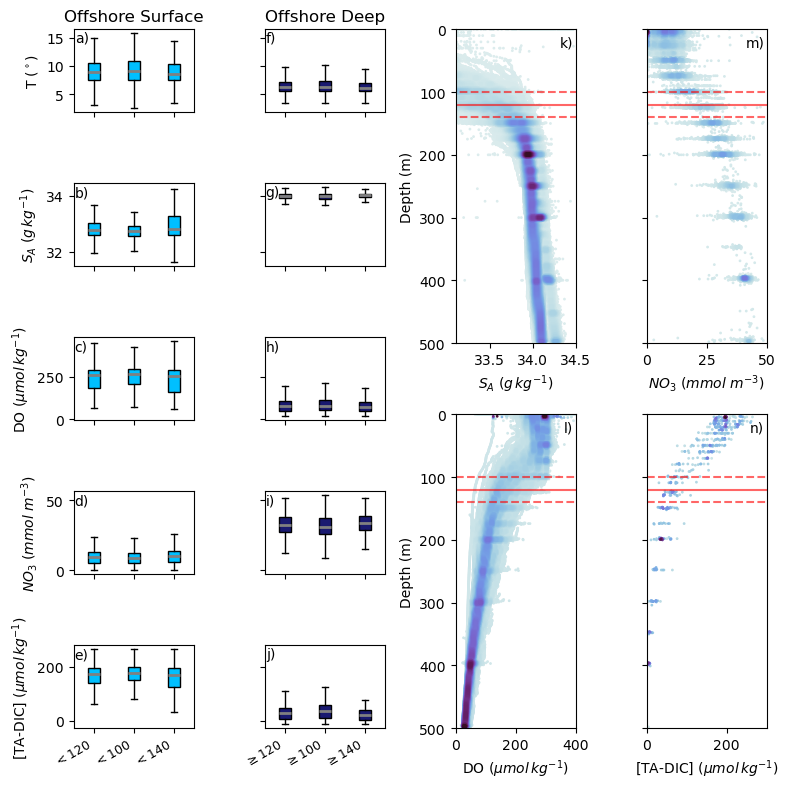

In [ ]:
# box plots of properties depending on depth split

fig = plt.figure(constrained_layout=True, figsize=[8,8])
gs = GridSpec(10, 4, figure=fig)
# surface
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:4,0])
ax3 = fig.add_subplot(gs[4:6,0])
ax4 = fig.add_subplot(gs[6:8,0])
ax5 = fig.add_subplot(gs[8:,0])

# deep
ax6 = fig.add_subplot(gs[:2,1])
ax7 = fig.add_subplot(gs[2:4,1])
ax8 = fig.add_subplot(gs[4:6,1])
ax9 = fig.add_subplot(gs[6:8,1])
ax10 = fig.add_subplot(gs[8:,1])

# TS diagrams
ax11 = fig.add_subplot(gs[:5,2])
ax12 = fig.add_subplot(gs[5:,2])
ax13 = fig.add_subplot(gs[:5,3])
ax14 = fig.add_subplot(gs[5:,3])


properties = ['temperature (degC)','salinity (g kg-1)','DO (umol kg-1)', 'NO3 (uM)','[TA-DIC]']
prop_labels = ['T ($^\circ$)','$S_A$ ($g\, kg^{-1}$)', 'DO ($\mu mol \,kg^{-1}$)','$NO_3$ ($mmol\,\,m^{-3}$)','[TA-DIC] ($\mu mol \,kg^{-1}$)']
bools = [(obs.location == 'offshore') & (obs['depth (m)'] < 120),
         (obs.location == 'offshore') & (obs['depth (m)'] < 120-20),
         (obs.location == 'offshore') & (obs['depth (m)'] < 120+20)]
axs = [ax1,ax2,ax3,ax4,ax5]
for i in range(len(properties)):
    bplot = box(obs,bools,properties[i],axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_ylabel(prop_labels[i])
    for patch in bplot['boxes']:
        patch.set_facecolor('deepskyblue')
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

bools = [(obs.location == 'offshore') & (obs['depth (m)'] >= 120),
         (obs.location == 'offshore') & (obs['depth (m)'] >= 120-20),
         (obs.location == 'offshore') & (obs['depth (m)'] >= 120+20)]
axs = [ax6,ax7,ax8,ax9,ax10]
for i in range(len(properties)):
    bplot = box(obs,bools,properties[i],axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xticklabels([])
    for patch in bplot['boxes']:
        patch.set_facecolor('midnightblue')
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
ax6.sharey(ax1)
ax7.sharey(ax2)
ax8.sharey(ax3)
ax9.sharey(ax4)
ax10.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax7.tick_params(axis='y', which='both', labelleft=False)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax9.tick_params(axis='y', which='both', labelleft=False)
ax10.tick_params(axis='y', which='both', labelleft=False)

ax5.set_xticklabels(['$<120$','$<100$','$<140$'],rotation=30,ha='right',fontsize=9)
ax10.set_xticklabels(['$\geq 120$','$\geq 100$','$\geq 140$'],rotation=30,ha='right',fontsize=9)
ax1.set_title('Offshore Surface')
ax6.set_title('Offshore Deep')


#########################
# Depth-tracer Diagrams #
#########################

depth_tracer(offall,ax11,'salinity (g kg-1)','depth (m)')
ax11.set_xlim([33.1,34.5])
ax11.set_ylim([500,0])
ax11.plot([28,34.5],[100,100],'r--',alpha=0.6)
ax11.plot([28,34.5],[120,120],'r',alpha=0.6)
ax11.plot([28,34.5],[140,140],'r--',alpha=0.6)
ax11.set_xlabel('$S_A$ ($g\, kg^{-1}$)')
ax11.set_ylabel('Depth (m)')

depth_tracer(offall,ax12,'DO (umol kg-1)','depth (m)')
ax12.set_xlim([0,400])
ax12.set_ylim([500,0])
ax12.plot([0,400],[100,100],'r--',alpha=0.6)
ax12.plot([0,400],[120,120],'r',alpha=0.6)
ax12.plot([0,400],[140,140],'r--',alpha=0.6)
ax12.set_xlabel('DO ($\mu mol \,kg^{-1}$)')
ax12.set_ylabel('Depth (m)')
# ax[1].set_xlim([28,34.4])

depth_tracer(offall,ax13,'NO3 (uM)','depth (m)')
ax13.set_xlim([0,50])
ax13.set_ylim([500,0])
ax13.plot([0,50],[100,100],'r--',alpha=0.6)
ax13.plot([0,50],[120,120],'r',alpha=0.6)
ax13.plot([0,50],[140,140],'r--',alpha=0.6)
ax13.set_xlabel('$NO_3$ ($mmol\,\,m^{-3}$)')
ax13.set_ylabel('')
ax13.set_yticklabels([])
# ax[2].set_xlim([28,34.4])

depth_tracer(offall,ax14,'[TA-DIC]','depth (m)')   
ax14.set_xlim([0,300])
ax14.set_ylim([500,0])
ax14.plot([0,300],[100,100],'r--',alpha=0.6)
ax14.plot([0,300],[120,120],'r',alpha=0.6)
ax14.plot([0,300],[140,140],'r--',alpha=0.6)
ax14.set_xlabel('[TA-DIC] ($\mu mol \,kg^{-1}$)')
ax14.set_ylabel('')
ax14.set_yticklabels([])


# add text to each figure
ax1.text(0.01,0.98,'a)',ha='left',va='top',transform=ax1.transAxes,fontsize=10)
ax2.text(0.01,0.98,'b)',ha='left',va='top',transform=ax2.transAxes,fontsize=10)
ax3.text(0.01,0.98,'c)',ha='left',va='top',transform=ax3.transAxes,fontsize=10)
ax4.text(0.01,0.98,'d)',ha='left',va='top',transform=ax4.transAxes,fontsize=10)
ax5.text(0.01,0.98,'e)',ha='left',va='top',transform=ax5.transAxes,fontsize=10)
ax6.text(0.01,0.98,'f)',ha='left',va='top',transform=ax6.transAxes,fontsize=10)
ax7.text(0.01,0.98,'g)',ha='left',va='top',transform=ax7.transAxes,fontsize=10)
ax8.text(0.01,0.98,'h)',ha='left',va='top',transform=ax8.transAxes,fontsize=10)
ax9.text(0.01,0.98,'i)',ha='left',va='top',transform=ax9.transAxes,fontsize=10)
ax10.text(0.01,0.98,'j)',ha='left',va='top',transform=ax10.transAxes,fontsize=10)
ax11.text(0.98,0.98,'k)',ha='right',va='top',transform=ax11.transAxes,fontsize=10) 
ax12.text(0.98,0.98,'l)',ha='right',va='top',transform=ax12.transAxes,fontsize=10)  
ax13.text(0.98,0.98,'m)',ha='right',va='top',transform=ax13.transAxes,fontsize=10)
ax14.text(0.98,0.98,'n)',ha='right',va='top',transform=ax14.transAxes,fontsize=10)


plt.tight_layout()
plt.savefig('offobssensitivity.jpg')

In [21]:
# print means
bools = [(obs.location == 'offshore') & (obs['depth (m)'] < 120),
         (obs.location == 'offshore') & (obs['depth (m)'] < 120-20),
         (obs.location == 'offshore') & (obs['depth (m)'] < 120+20)]

## shallow, 120 m divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[0]]),2))

print('\n')
## shallow, 100 m divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[1]]),2))

print('\n')
## shallow, 140 m divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[2]]),2))

temperature (degC) = 8.95
salinity (g kg-1) = 32.91
DO (umol kg-1) = 236.93
NO3 (uM) = 9.47
[TA-DIC] = 164.63


temperature (degC) = 9.05
salinity (g kg-1) = 32.87
DO (umol kg-1) = 243.31
NO3 (uM) = 8.86
[TA-DIC] = 170.82


temperature (degC) = 8.84
salinity (g kg-1) = 32.98
DO (umol kg-1) = 229.15
NO3 (uM) = 10.25
[TA-DIC] = 156.71


In [22]:
# print means
bools = [(obs.location == 'offshore') & (obs['depth (m)'] >= 120),
         (obs.location == 'offshore') & (obs['depth (m)'] >= 120-20),
         (obs.location == 'offshore') & (obs['depth (m)'] >= 120+20)]

## deep, 120 m divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[0]]),2))

print('\n')
## deep, 100 m divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[1]]),2))

print('\n')
## deep, 140 m divison
for prop in properties:
    print(prop,'=',np.round(np.mean(obs[prop][bools[2]]),2))

temperature (degC) = 6.37
salinity (g kg-1) = 33.96
DO (umol kg-1) = 84.03
NO3 (uM) = 32.34
[TA-DIC] = 29.53


temperature (degC) = 6.47
salinity (g kg-1) = 33.92
DO (umol kg-1) = 89.47
NO3 (uM) = 30.71
[TA-DIC] = 34.16


temperature (degC) = 6.28
salinity (g kg-1) = 34.0
DO (umol kg-1) = 79.47
NO3 (uM) = 33.49
[TA-DIC] = 23.57
